***First we import the libraries for reading to datas***

In [2]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ------------------------------------ --- 1.3/1.4 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.5/101.7 MB 4.2 MB/s eta 0:00:24
   - -------------------------------------- 3.1/101.7 MB 10.3 MB/s eta 0:00:10
   -- ------------------------------------- 5.5/101.7 MB 11.6 MB/s eta 0:00:09
   -- ------------------------------------- 7.6/101.7 MB 11.7 MB/s eta 0:00:09
   ---- ----------------------------------- 11.3/101.7 MB 12.4 MB/s eta 0:00:08
   ----- ---------------------------------- 14.4/101.7 MB 12.8 MB/s eta 0:00:07
   ------ --------------------------------- 17.3/101.7 MB 13.0 MB/s eta 0:00:07
   ------- -------------------------------- 20.2/101.7 MB 13.2 MB/s eta 0:00:07
   -

In [4]:
!pip install imbalanced-learn

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import scipy.cluster.hierarchy as sch

warnings.filterwarnings('ignore')


In [6]:
arecords = pd.read_csv('input/application_record.csv', encoding='utf-8')
crecords = pd.read_csv('input/credit_record.csv', encoding='utf-8')

***We begin by displaying the first 10 rows of both `arecords` and `crecords` DataFrames to get an initial understanding of the data and its structure.***

In [7]:
arecords.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0


In [8]:
crecords.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


***In this step, we create a new column `accountAge` in the `crecords` DataFrame by converting `MONTHS_BALANCE` to a positive value. We then sort the `crecords` DataFrame based on `ID` and `accountAge`.***

In [9]:
crecords['accountAge'] = crecords['MONTHS_BALANCE']*-1
crecords.sort_values(['ID', 'accountAge'], ascending=True, inplace=True)

***We print basic information about the `arecords` and `crecords` DataFrames to understand their structure, including column names and data types. We also check the shape of both DataFrames and the number of unique IDs in each.***

In [ ]:
print(arecords.info())
print("--------------------------------")
print(crecords.info())
print(arecords.shape)
print(crecords.shape)
print(arecords['ID'].nunique())
print(crecords['ID'].nunique())

***Here, we identify the number of common IDs between `arecords` and `crecords`. We also check for missing values in both DataFrames and visualize these missing values using heatmaps.***

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64
--------------------------------

ID                0
MONTHS_BALANCE    0
STATUS            0
accountAge        0
dtype: int64


<Axes: >

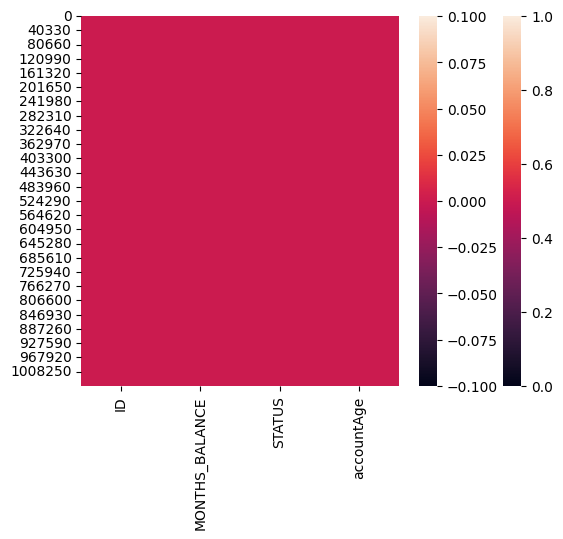

In [10]:
len(set(crecords['ID']).intersection(set(arecords['ID'])))
print(arecords.isna().sum())
print("\n--------------------------------\n")
print(crecords.isna().sum())
sns.heatmap(arecords.isna(), color='red')
sns.heatmap(crecords.isna(), color='red')

***We remove duplicate rows from the `arecords` DataFrame based on the `ID` column, keeping the last occurrence. We also drop the `OCCUPATION_TYPE` column and rename several columns for better clarity.***

In [11]:
arecords.drop_duplicates('ID', keep='last', inplace=True)
arecords.drop('OCCUPATION_TYPE', axis=1, inplace=True) 
arecords.info()
arecords.rename(columns={'CODE_GENDER':'gender','FLAG_OWN_CAR':'car','FLAG_OWN_REALTY':'reality',
                         'CNT_CHILDREN':'childNo','AMT_INCOME_TOTAL':'incm',
                         'NAME_EDUCATION_TYPE':'eduTp','NAME_FAMILY_STATUS':'familyTp',
                        'NAME_HOUSING_TYPE':'houseTp','FLAG_EMAIL':'mail',
                         'NAME_INCOME_TYPE':'incmTp','FLAG_MOBIL':'mobilePhone',
                         'FLAG_WORK_PHONE':'workPhone', 'FLAG_PHONE':'phone',
                         'CNT_FAM_MEMBERS':'famSize',
                        },inplace=True)
arecords.info()

<class 'pandas.core.frame.DataFrame'>
Index: 438510 entries, 0 to 438556
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438510 non-null  int64  
 1   CODE_GENDER          438510 non-null  object 
 2   FLAG_OWN_CAR         438510 non-null  object 
 3   FLAG_OWN_REALTY      438510 non-null  object 
 4   CNT_CHILDREN         438510 non-null  int64  
 5   AMT_INCOME_TOTAL     438510 non-null  float64
 6   NAME_INCOME_TYPE     438510 non-null  object 
 7   NAME_EDUCATION_TYPE  438510 non-null  object 
 8   NAME_FAMILY_STATUS   438510 non-null  object 
 9   NAME_HOUSING_TYPE    438510 non-null  object 
 10  DAYS_BIRTH           438510 non-null  int64  
 11  DAYS_EMPLOYED        438510 non-null  int64  
 12  FLAG_MOBIL           438510 non-null  int64  
 13  FLAG_WORK_PHONE      438510 non-null  int64  
 14  FLAG_PHONE           438510 non-null  int64  
 15  FLAG_EMAIL           4

***We first identify which columns in the `arecords` DataFrame are categorical and which are numerical. This helps us understand the types of data we are working with and how to process them.***

In [12]:
categorical_columns = arecords.select_dtypes(include='object').columns.tolist()
numerical_columns = arecords.select_dtypes(exclude='object').columns.tolist()

print("Categorical Columns:")
print(categorical_columns)
print("\nNumerical Columns:")
print(numerical_columns)

Categorical Columns:
['gender', 'car', 'reality', 'incmTp', 'eduTp', 'familyTp', 'houseTp']

Numerical Columns:
['ID', 'childNo', 'incm', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'mobilePhone', 'workPhone', 'phone', 'mail', 'famSize']


***We explore the unique values in each column of the `arecords` DataFrame and count the number of unique values. This helps us understand the data distribution within each column.***

In [14]:
for column in arecords.columns:
    unique_values = arecords[column].unique()
    print(f"\nColumn: {column}")
    print(f"Unique Values: {unique_values}")
    print(f"Number of Unique Values: {len(unique_values)}")

arecords.columns


Column: ID
Unique Values: [5008804 5008805 5008806 ... 6841878 6842765 6842885]
Number of Unique Values: 438510

Column: gender
Unique Values: ['M' 'F']
Number of Unique Values: 2

Column: car
Unique Values: ['Y' 'N']
Number of Unique Values: 2

Column: reality
Unique Values: ['Y' 'N']
Number of Unique Values: 2

Column: childNo
Unique Values: [ 0  1  3  2  4  5 14 19  7  9 12  6]
Number of Unique Values: 12

Column: incm
Unique Values: [ 427500.    112500.    270000.    283500.    135000.    130500.
  157500.    405000.    211500.    360000.    126000.    315000.
  247500.    297000.    225000.    166500.    216000.    255150.
  148500.    202500.     94500.    450000.    180000.     90000.
  765000.    382500.    144000.    229500.    292500.     74250.
   40500.    337500.    193500.    267750.    139500.     67500.
  252000.    900000.    115290.    279000.     76500.    234000.
   81000.    108000.     99000.    198000.     45000.    238500.
  117000.    153000.   1350000.    445

Index(['ID', 'gender', 'car', 'reality', 'childNo', 'incm', 'incmTp', 'eduTp',
       'familyTp', 'houseTp', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'mobilePhone',
       'workPhone', 'phone', 'mail', 'famSize'],
      dtype='object')

***To prepare the data for modeling, we convert categorical variables into numerical format using Label Encoding. This process involves assigning unique integers to each category in the categorical columns.***

In [15]:
categorical_columns = ['gender', 'car', 'reality', 'incmTp', 'eduTp', 'familyTp', 'houseTp']

label_encoders = {}

for column in categorical_columns:
    if column in arecords.columns:
        le = LabelEncoder()
        arecords[column] = le.fit_transform(arecords[column].astype(str))
        label_encoders[column] = le

print("\nNumerical Version of Categorical Variables:")
print(arecords[categorical_columns].head())
print("\nSummary of the Data:")
print(arecords.describe(include='all'))

print("\nFirst 5 Rows of the Data:")
print(arecords.head())


Numerical Version of Categorical Variables:
   gender  car  reality  incmTp  eduTp  familyTp  houseTp
0       1    1        1       4      1         0        4
1       1    1        1       4      1         0        4
2       1    1        1       4      4         1        1
3       0    0        1       0      4         3        1
4       0    0        1       0      4         3        1

Summary of the Data:
                 ID         gender            car        reality  \
count  4.385100e+05  438510.000000  438510.000000  438510.000000   
mean   6.022035e+06       0.328608       0.371900       0.693355   
std    5.714962e+05       0.469708       0.483313       0.461101   
min    5.008804e+06       0.000000       0.000000       0.000000   
25%    5.609362e+06       0.000000       0.000000       0.000000   
50%    6.047720e+06       0.000000       0.000000       1.000000   
75%    6.454161e+06       1.000000       1.000000       1.000000   
max    7.999952e+06       1.000000       

***We use scatter plots to visualize the distribution and relationships of various numerical columns in the `arecords` DataFrame. This helps us gain insights into the patterns and correlations between different features.***

<Axes: xlabel='ID', ylabel='famSize'>

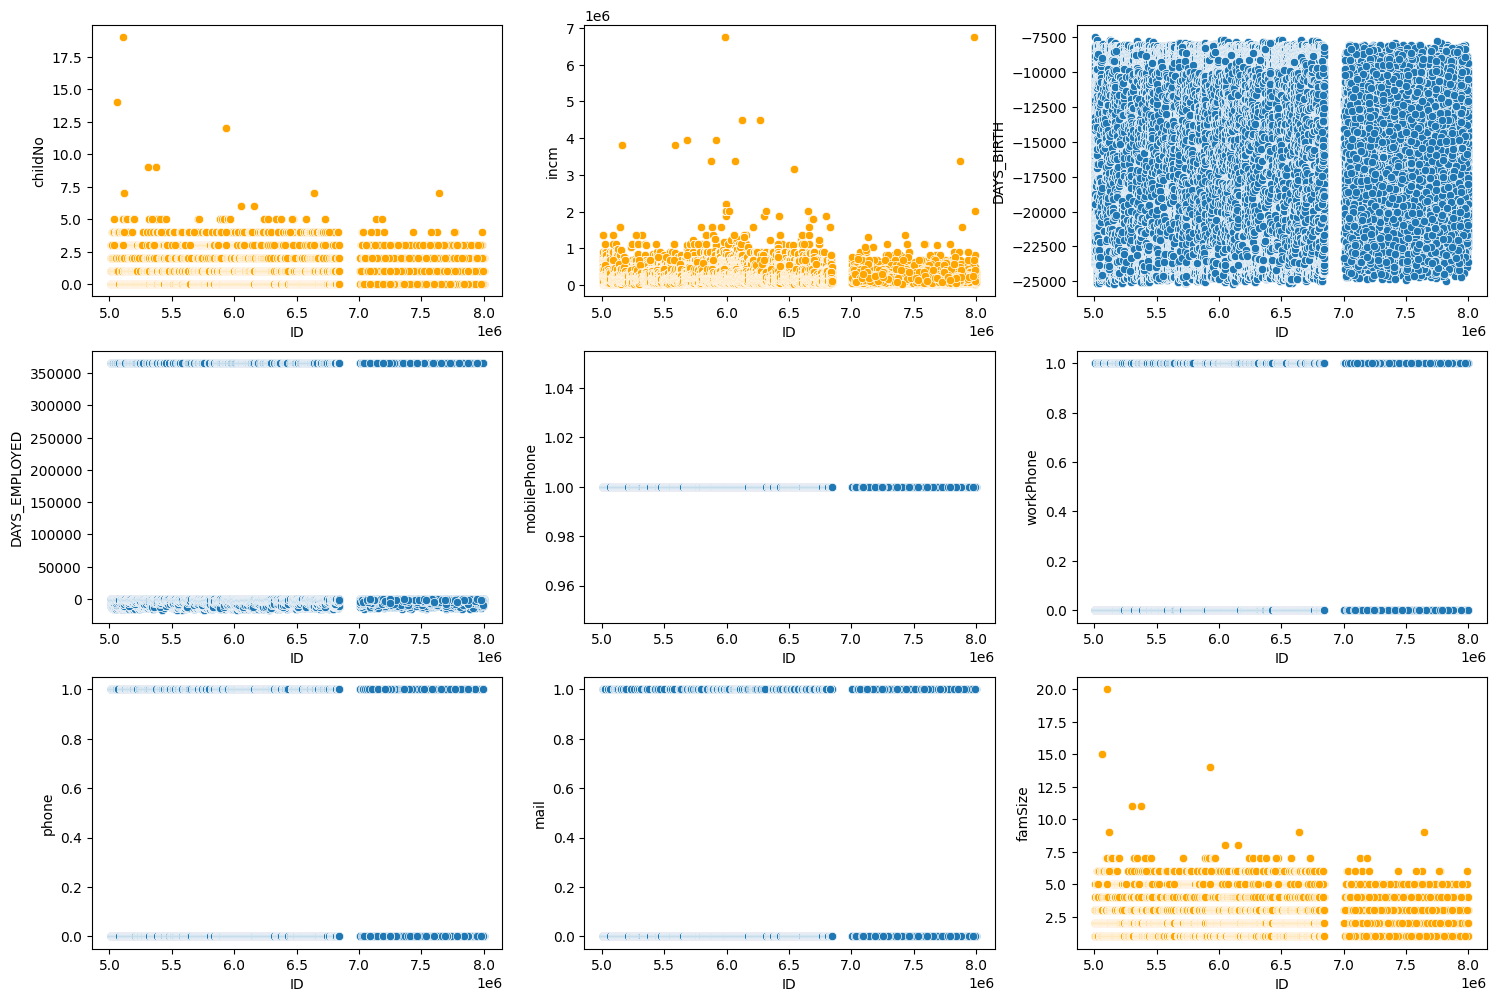

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))

sns.scatterplot(x='ID', y='childNo', data=arecords, ax=ax[0][0], color='orange')
sns.scatterplot(x='ID', y='incm', data=arecords, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=arecords, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=arecords, ax=ax[1][0])
sns.scatterplot(x='ID', y='mobilePhone', data=arecords, ax=ax[1][1])
sns.scatterplot(x='ID', y='workPhone', data=arecords, ax=ax[1][2])
sns.scatterplot(x='ID', y='phone', data=arecords, ax=ax[2][0])
sns.scatterplot(x='ID', y='mail', data=arecords, ax=ax[2][1])
sns.scatterplot(x='ID', y='famSize', data=arecords, ax=ax[2][2], color='orange')

***To ensure the data is clean and to prevent outliers from skewing the results, we remove outliers for the `childNo`, `incm`, and `famSize` columns. We do this by filtering the data to only include values within the 0.001 and 0.999 quantiles.***

In [17]:
q_hi_childNo = arecords['childNo'].quantile(0.999)
q_low_childNo = arecords['childNo'].quantile(0.001)
arecords = arecords[(arecords['childNo'] > q_low_childNo) & (arecords['childNo'] < q_hi_childNo)]

# For 'incm' (Total Income)
q_hi_incm = arecords['incm'].quantile(0.999)
q_low_incm = arecords['incm'].quantile(0.001)
arecords = arecords[(arecords['incm'] > q_low_incm) & (arecords['incm'] < q_hi_incm)]

# For 'famSize' (Family Size)
q_hi_famSize = arecords['famSize'].quantile(0.999)
q_low_famSize = arecords['famSize'].quantile(0.001)
arecords = arecords[(arecords['famSize'] > q_low_famSize) & (arecords['famSize'] < q_hi_famSize)]

***We use scatter plots to visualize the cleaned data distributions and relationships between `ID` and several other features. This helps us understand the data after outlier removal and confirm that the feature distributions are as expected.***

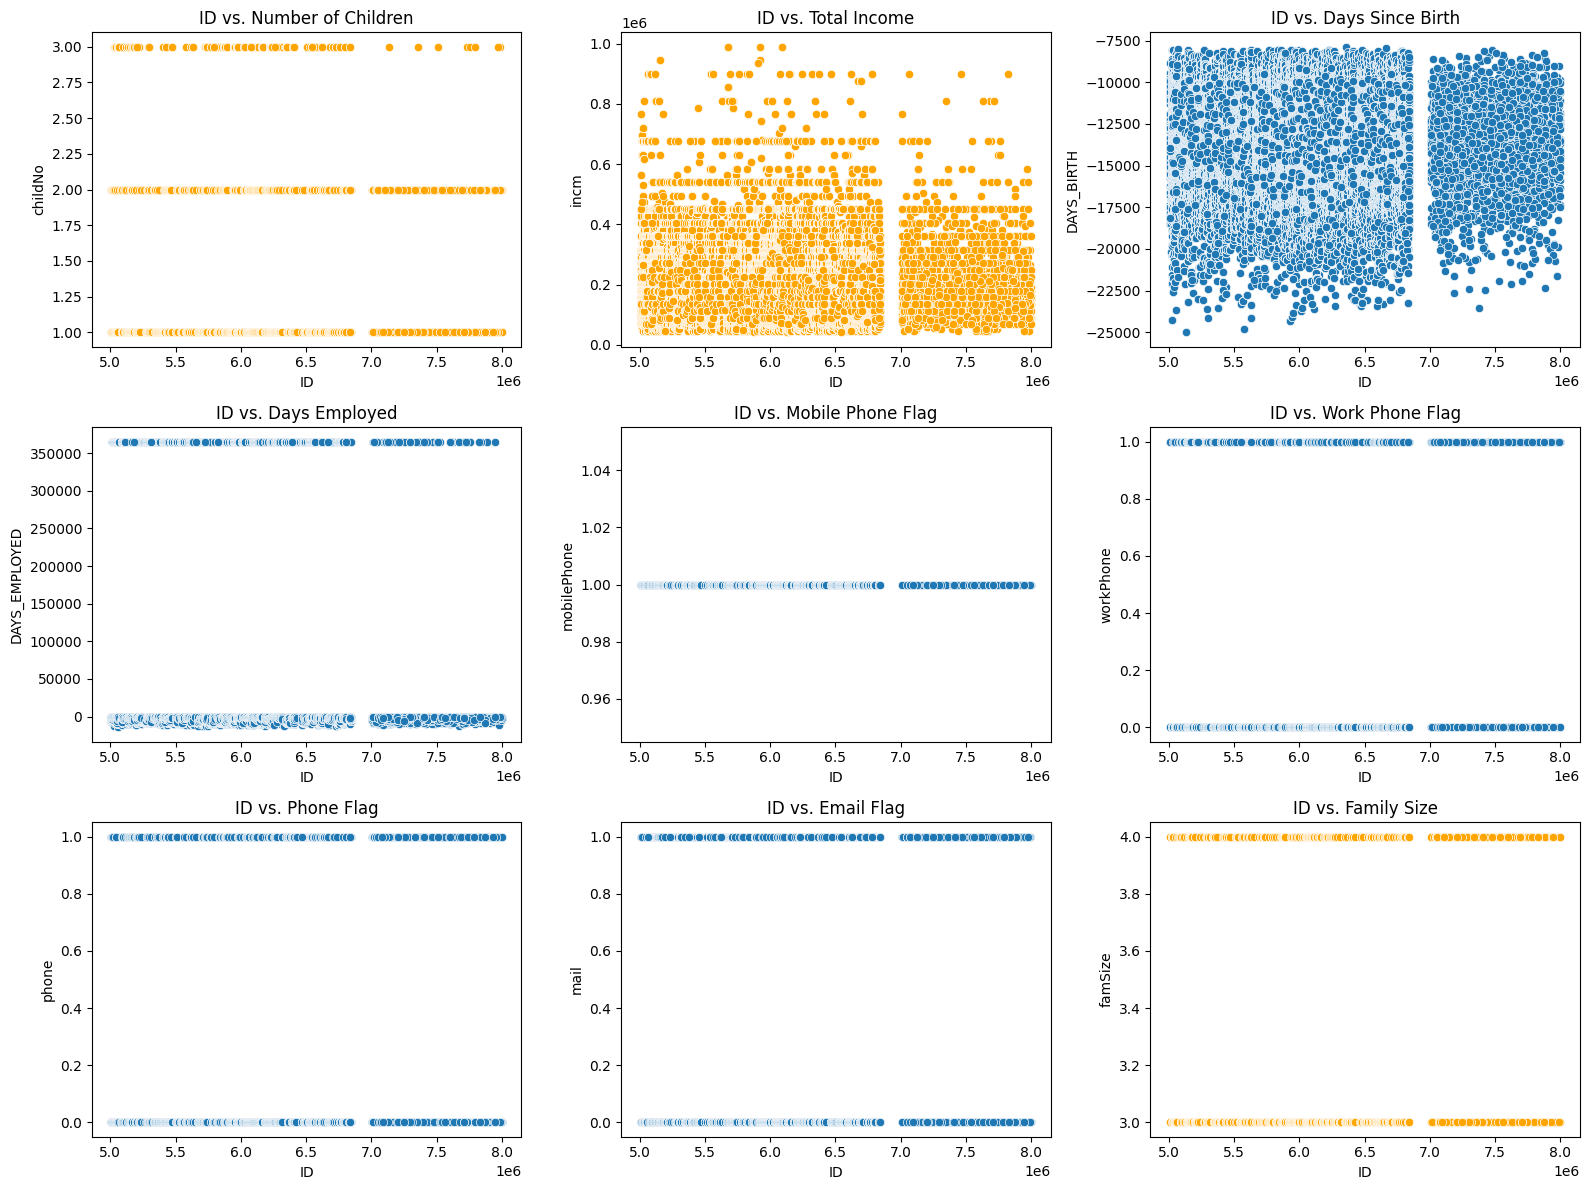

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

sns.scatterplot(x='ID', y='childNo', data=arecords, ax=ax[0][0], color='orange')
ax[0][0].set_title('ID vs. Number of Children')

sns.scatterplot(x='ID', y='incm', data=arecords, ax=ax[0][1], color='orange')
ax[0][1].set_title('ID vs. Total Income')

sns.scatterplot(x='ID', y='DAYS_BIRTH', data=arecords, ax=ax[0][2])
ax[0][2].set_title('ID vs. Days Since Birth')

sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=arecords, ax=ax[1][0])
ax[1][0].set_title('ID vs. Days Employed')

sns.scatterplot(x='ID', y='mobilePhone', data=arecords, ax=ax[1][1])
ax[1][1].set_title('ID vs. Mobile Phone Flag')

sns.scatterplot(x='ID', y='workPhone', data=arecords, ax=ax[1][2])
ax[1][2].set_title('ID vs. Work Phone Flag')

sns.scatterplot(x='ID', y='phone', data=arecords, ax=ax[2][0])
ax[2][0].set_title('ID vs. Phone Flag')

sns.scatterplot(x='ID', y='mail', data=arecords, ax=ax[2][1])
ax[2][1].set_title('ID vs. Email Flag')

sns.scatterplot(x='ID', y='famSize', data=arecords, ax=ax[2][2], color='orange')
ax[2][2].set_title('ID vs. Family Size')

plt.tight_layout()
plt.show()

***Finally, we print the shapes of the `arecords` and `crecords` DataFrames, the number of unique IDs in each DataFrame, and the column names. This gives us a summary of the data structure and helps us ensure everything is in order.***

In [19]:
print(arecords.shape)
print(crecords.shape)
print(arecords['ID'].nunique())
print(crecords['ID'].nunique())
print(arecords.columns)
print(crecords.columns)

(114187, 17)
(1048575, 4)
114187
45985
Index(['ID', 'gender', 'car', 'reality', 'childNo', 'incm', 'incmTp', 'eduTp',
       'familyTp', 'houseTp', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'mobilePhone',
       'workPhone', 'phone', 'mail', 'famSize'],
      dtype='object')
Index(['ID', 'MONTHS_BALANCE', 'STATUS', 'accountAge'], dtype='object')


***In this step, we preprocess the `STATUS` column in the `crecords` DataFrame. Initially, we replace the values 'C' and 'X' with 0, convert the column to integers, and then apply a lambda function to categorize the values into binary outcomes (0 or 1). We finally replace these binary values with 'No' and 'Yes' for better interpretability.***

In [20]:
crecords.STATUS.value_counts()
crecords.STATUS.replace({'C': 0, 'X': 0}, inplace=True)
crecords.STATUS = crecords.STATUS.astype('int')
crecords.STATUS = crecords.STATUS.apply(lambda x: 1 if x >= 2 else 0)
crecords.STATUS.replace({0: 'No', 1: 'Yes'}, inplace=True)
print(crecords.STATUS.value_counts())
crecords.STATUS.value_counts(normalize=True)

STATUS
No     1045471
Yes       3104
Name: count, dtype: int64


STATUS
No     0.99704
Yes    0.00296
Name: proportion, dtype: float64

***We aggregate the `crecords` DataFrame to get the maximum values for each `ID` and merge it with the `arecords` DataFrame on the `ID` column. We then drop the `MONTHS_BALANCE` column and select features for clustering. The selected features are scaled using `StandardScaler` to normalize their ranges.***

In [21]:
cr_df = crecords.groupby('ID').agg(max).reset_index()
df = arecords.merge(cr_df, on='ID', how='inner')
df.head()
df.drop(['MONTHS_BALANCE'], axis=1, inplace=True)
df.columns
features = ['incm', 'childNo', 'DAYS_BIRTH', 'famSize']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Determining the Optimal Number of Clusters with Elbow Method

We use the Elbow Method to determine the optimal number of clusters for K-Means clustering. By plotting the Within-Cluster Sum of Squares (WCSS) against the number of clusters, we can visually identify the point where adding more clusters does not significantly reduce WCSS. This point indicates the optimal number of clusters.


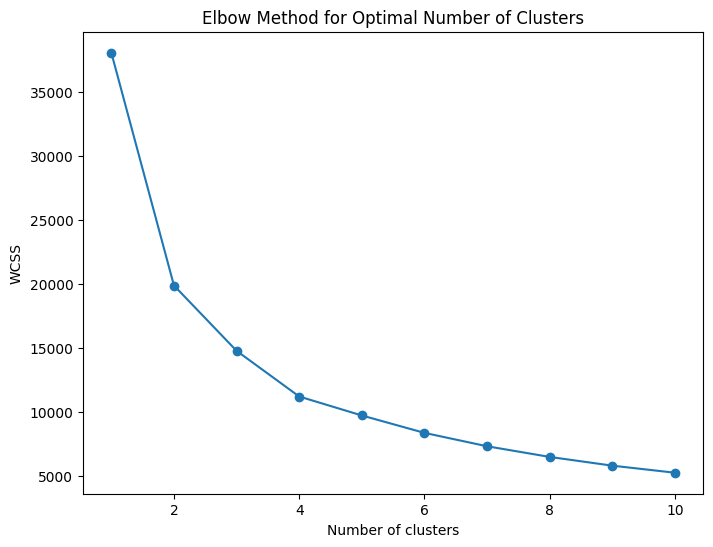

In [22]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

optimal_clusters = 4

## Applying K-Means Clustering and Visualizing Results with PCA

With the optimal number of clusters determined, we apply K-Means clustering to our data. We then use Principal Component Analysis (PCA) to reduce the dimensionality of the data to two components for visualization. Finally, we plot the PCA-transformed data, colored by the K-Means clusters, to visualize the clustering results.


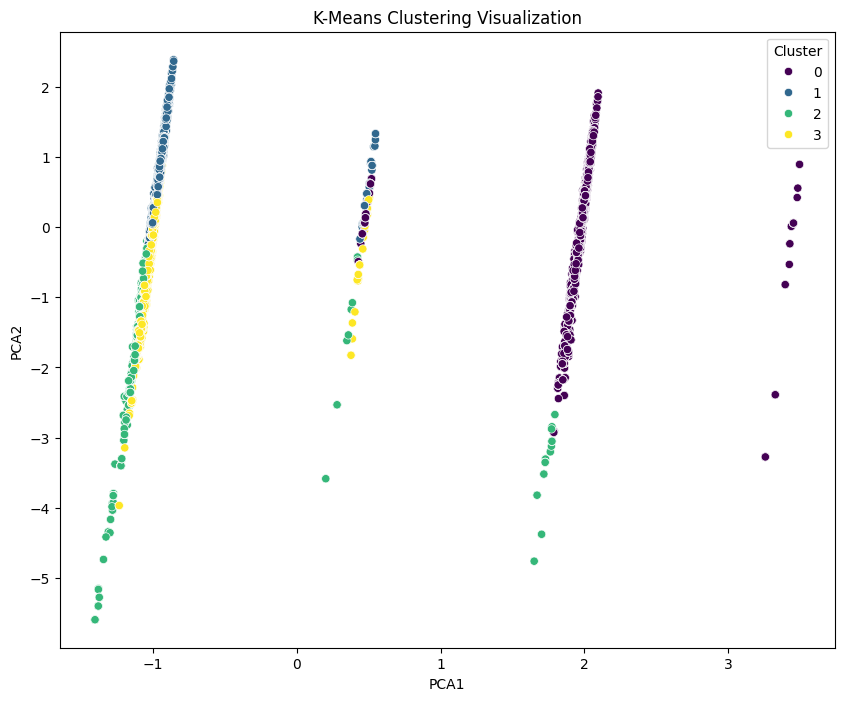

In [23]:
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_unsup = df
df_unsup['PCA1'] = X_pca[:, 0]
df_unsup['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='viridis', data=df_unsup, marker='o')
plt.title('K-Means Clustering Visualization')
plt.legend(title='Cluster')
plt.show()

## Applying Agglomerative Clustering and Dendrogram Visualization

We apply Agglomerative Clustering to our dataset with the number of clusters set to 4. This clustering technique builds clusters by merging pairs of clusters iteratively based on their distance. We also visualize the hierarchical clustering process using a dendrogram to understand the merging process and the distances between clusters.

First, the data is scaled using `StandardScaler` to standardize the features. The `AgglomerativeClustering` model is then applied to the scaled data, and the resulting cluster labels are added to the DataFrame.

Finally, a dendrogram is plotted to visualize the hierarchical clustering results.


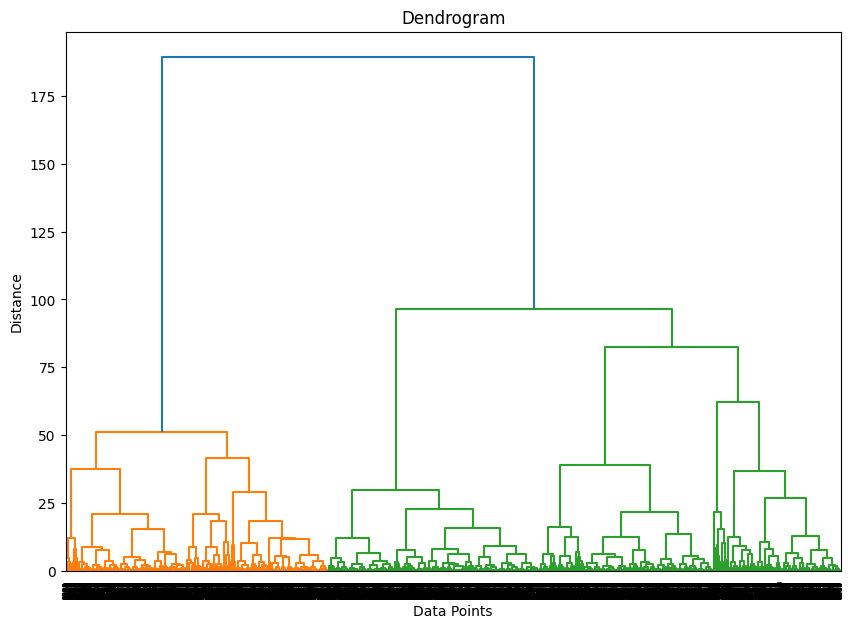

In [24]:
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

agg_clustering = AgglomerativeClustering(n_clusters=4)
df_unsup['Agglomerative_Cluster'] = agg_clustering.fit_predict(X_scaled)

plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

In [25]:
df[['ID', 'Agglomerative_Cluster']].head()

,ID,Agglomerative_Cluster
0,5008838,0
1,5008839,0
2,5008840,0
3,5008841,0
4,5008842,0


## Reorganizing DataFrame and Handling Missing Values

In this step, we reorder the columns of the DataFrame to ensure that the `STATUS` column is placed at the end. We then convert the `STATUS` column to binary format, where 'Yes' is encoded as 1 and 'No' as 0. Finally, we check for any missing values in the DataFrame.

This organization and encoding are essential for preparing the dataset for machine learning models, ensuring that the features and target variable are correctly formatted and missing values are identified.


In [26]:
columns = [col for col in df.columns if col != 'STATUS']  # Select columns other than 'STATUS'
columns.append('STATUS')  # Append 'STATUS' column at the end

df = df[columns]
df['STATUS'] = df['STATUS'].apply(lambda x: 1 if x == 'Yes' else 0)

print(df.columns)
df.isna().sum()

Index(['ID', 'gender', 'car', 'reality', 'childNo', 'incm', 'incmTp', 'eduTp',
       'familyTp', 'houseTp', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'mobilePhone',
       'workPhone', 'phone', 'mail', 'famSize', 'accountAge', 'KMeans_Cluster',
       'PCA1', 'PCA2', 'Agglomerative_Cluster', 'STATUS'],
      dtype='object')


ID                       0
gender                   0
car                      0
reality                  0
childNo                  0
incm                     0
incmTp                   0
eduTp                    0
familyTp                 0
houseTp                  0
DAYS_BIRTH               0
DAYS_EMPLOYED            0
mobilePhone              0
workPhone                0
phone                    0
mail                     0
famSize                  0
accountAge               0
KMeans_Cluster           0
PCA1                     0
PCA2                     0
Agglomerative_Cluster    0
STATUS                   0
dtype: int64

## Data Preprocessing and Resampling

In this step, we perform several preprocessing tasks on the dataset to prepare it for model training:

1. **Splitting Data:** The dataset is split into training and testing sets using `train_test_split`, with 20% of the data allocated for testing.

2. **Scaling Features:** The features are scaled using `MinMaxScaler` to normalize the data, ensuring that all features contribute equally to the model training.

3. **Handling Imbalanced Data:** To address class imbalance, `SMOTE` (Synthetic Minority Over-sampling Technique) is applied to the training and testing sets to generate synthetic samples and balance the class distribution.

We then check the distribution of classes in the original and resampled datasets to verify the balancing process.


In [27]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
mms = MinMaxScaler()

X_scl = pd.DataFrame(mms.fit_transform(X_train), columns=X_train.columns)
X_test_scl = pd.DataFrame(mms.transform(X_test), columns=X_test.columns)

oversample = SMOTE()
X_blc, y_blc = oversample.fit_resample(X_scl, y_train)
X_test_blc, y_test_blc = oversample.fit_resample(X_test_scl, y_test)

print(y_train.value_counts())
print(y_blc.value_counts())
print(y_test.value_counts())
print(y_test_blc.value_counts())

STATUS
0    7493
1     119
Name: count, dtype: int64
STATUS
0    7493
1    7493
Name: count, dtype: int64
STATUS
0    1872
1      32
Name: count, dtype: int64
STATUS
0    1872
1    1872
Name: count, dtype: int64


## Model Training and Evaluation

In this step, various classification models are trained and evaluated:

1. **Model Initialization:** Several classifiers are initialized, including Decision Tree, Random Forest, K-Nearest Neighbors, Support Vector Classifier, XGBoost, CatBoost, LightGBM, and Logistic Regression.

2. **Model Training:** Each classifier is trained using the balanced training data (`X_blc` and `y_blc`).

3. **Model Evaluation:** The performance of each classifier is evaluated on both the training and test datasets. The accuracy scores for each classifier are recorded and displayed.

This process helps in comparing the performance of different classification models to identify the best-performing one for the given dataset.


In [28]:
classifiers = {
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "KNeighbors": KNeighborsClassifier(),
    "SVC": SVC(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "LightGBM": LGBMClassifier(),
    "LogisticRegression": LogisticRegression(),
}

train_results = []
test_results = []

for key, classifier in classifiers.items():
    classifier.fit(X_blc, y_blc)
    train_result = classifier.score(X_blc, y_blc)
    train_results.append(train_result)
    test_result = classifier.score(X_test_blc, y_test_blc)
    test_results.append(test_result)

print("Train Results:\n", train_results)
print("Test Results:\n", test_results)

[LightGBM] [Info] Number of positive: 7493, number of negative: 7493
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4901
[LightGBM] [Info] Number of data points in the train set: 14986, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Train Results:
 [0.9991992526357935, 0.9991992526357935, 0.9841185106099026, 0.9506873081542774, 0.9979314026424663, 0.9966635526491392, 0.9953957026558121, 0.6759642332843988]
Test Results:
 [0.7542735042735043, 0.7927350427350427, 0.750534188034188, 0.8199786324786325, 0.8993055555555556, 0.9147970085470085, 0.8993055555555556, 0.6180555555555556]


## Hyperparameter Tuning with Grid Search

In this section, we perform hyperparameter tuning for the CatBoost classifier using `GridSearchCV`. This process helps in finding the optimal hyperparameters for the model to improve its performance.

1. **Parameter Grid Definition:** We define a parameter grid that includes different values for `iterations`, `depth`, `learning_rate`, and `l2_leaf_reg`.

2. **GridSearchCV Setup:** We create a `GridSearchCV` instance with the CatBoost model and the defined parameter grid. The grid search performs a 5-fold cross-validation to find the best hyperparameters based on accuracy.

3. **Fitting Grid Search:** The grid search is fitted to the balanced training data, and the best hyperparameters and corresponding accuracy score are printed.

This step ensures that the CatBoost model is tuned for the best possible performance based on the specified hyperparameters.


In [29]:
param_grid = {
    'iterations': [10, 25, 50],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

catboost_model = CatBoostClassifier(verbose=0)

grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_blc, y_blc)


print("Best hyperparameters:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)

Best hyperparameters: {'depth': 8, 'iterations': 50, 'l2_leaf_reg': 1, 'learning_rate': 0.2}
Best accuracy score: 0.9912591711124067


## Model Evaluation with Cross-Validation and Performance Metrics

After tuning the CatBoost model, we evaluate its performance using cross-validation and performance metrics.

1. **Cross-Validation:** We use `cross_val_score` to evaluate the performance of the best model found by `GridSearchCV` on the balanced training data. The cross-validation results are printed, along with the average accuracy score.

2. **Classification Report:** The best CatBoost model is used to make predictions on the balanced test set. A classification report is generated to provide a detailed performance summary, including precision, recall, and F1-score.

These evaluations help in understanding the effectiveness of the model and its ability to generalize to unseen data.


In [30]:
# Evaluate performance with cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, X_blc, y_blc, cv=5, scoring='accuracy')

print("Cross-validation results:", cv_scores)
print("Average CV accuracy:", cv_scores.mean())


#best model with best hyperparameters
best_catboost_model = grid_search.best_estimator_
preds = best_catboost_model.predict(X_test_blc)

print(classification_report(y_test_blc, preds))


Cross-validation results: [0.98132088 0.99499499 0.99099099 0.99432766 0.99466133]
Average CV accuracy: 0.9912591711124067
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1872
           1       0.99      0.74      0.85      1872

    accuracy                           0.87      3744
   macro avg       0.89      0.87      0.86      3744
weighted avg       0.89      0.87      0.86      3744

